In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torch
import copy

from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import Dataset, DataLoader
# from numba import cuda


In [5]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [6]:
d = 2 # dimension of the problem, either 2 or 3, this is d_0
hn = 4 # number of hidden layers, do not change this value
num_samples = 128 * 128

In [7]:
# function in dim 1
def n_g_square(z): 
    return z **2.0
    
def n_g_trig(z):
    return torch.sin(3*z*torch.pi) # argmax in 1/6 and 5/6

def my_log(z):
    return torch.log(z)/(torch.log(z) - 1.0)

def n_g_log(z):
    return z.detach().apply_(lambda x : 1.0 if x ==0 else torch.log(torch.tensor(x))/(torch.log(torch.tensor(x)) - 1.0))

def chv(z):
    return 2*z - 1.0

def loc_max(z):
    return (25*((chv(z))**3)*(1.0 - 4.0*(chv(z))**2)*torch.exp(-5.0*((chv(z))**2)))/0.8143


In [8]:
# functions to test in dimension d > 1

def n_g_dim(z, d = d):
    return (1/d) * torch.sum(z**2, dim=1)

def my_log_dim(z, d = d):
    return (1/d) * torch.sum(my_log(z), dim=1)

def n_g_trig_dim(z, d = d):
    return (1/d) * torch.sum(torch.abs(torch.sin(2*z*torch.pi)), dim=1)

def loc_max_dim(z, d = d):
    return (1/d) * torch.sum(loc_max(z), dim=1)

In [9]:
# NN with leaky relu as activation with two hidden layer
class LeakyNN_weight(nn.Module):
    def __init__(self, input_size, n_hidden1, n_hidden2, output_size):
        super(LeakyNN_weight, self).__init__()
        self.fc1 = nn.Linear(input_size, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_hidden2)
        self.fc4 = nn.Linear(n_hidden2, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [10]:
# Modular version of LeakyNN_weight, parametrized by L
class LeakyNN(nn.Module):
    def __init__(self, L = 4, input_size = d, n_hidden = 4, output_size = 1):
        """
        L: number of layers, number of hidden layers = L-2
        input_size: dimension of input, here equal to 2 or 3
        n_hidden: width of each hidden layer
        output_size: dimension of output, here equal to 1
        """
        super().__init__()  # Call the parent class's constructor directly
        
        # Ensure that the number of parameters does not change based on L
        assert L >= 2, "L should be at least 2"
        
        # Initialize layers list
        layers = []
        
        # First hidden layer (input_size to n_hidden)
        layers.append(nn.Linear(input_size, n_hidden))
        
        # Add L-2 hidden layers (n_hidden to n_hidden)
        for _ in range(L - 2):
            layers.append(nn.Linear(n_hidden, n_hidden))
        
        # Output layer (n_hidden to output_size)
        layers.append(nn.Linear(n_hidden, output_size))
        
        # Register the layers as ModuleList
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        # Apply LeakyReLU activation after each hidden layer
        for i in range(len(self.layers) - 1):  # Skip the last layer for activation
            x = F.leaky_relu(self.layers[i](x))
        
        # No activation function on the output layer
        x = self.layers[-1](x)
        return x


In [11]:
L = 4 # To be changed, once you start question 2

In [12]:
#loss function
loss_func = nn.MSELoss(reduction = 'mean')

# data set for training and validation
def data_tr_val(sigO = torch.tensor(0.1, device = device), batch_size = 128, nbBatch = 128, nbBatchVal = 16, d = d):
    """
    Generates random training and validation datasets with added Gaussian noise.

    Parameters:
        sigO (torch.tensor): Standard deviation of the noise to be added.
        batch_size (int): Number of samples per batch.
        nbBatch (int): Number of batches for the training set.
        nbBatchVal (int): Number of batches for the validation set.
        d (int): Dimension of the input data.

    Returns:
        dataT (DataLoader): PyTorch DataLoader for the training set.
        dataV (DataLoader): PyTorch DataLoader for the validation set.
    """
    # Generate random input data for training (uniformly distributed in [0,1])
    U_train = torch.rand((nbBatch*batch_size, d), device = device)
    #U_train = torch.rand((nbBatch*batch_size, d)).view(-1,1)

    # Generate random input data for validation (same as training)
    U_val = torch.rand((nbBatchVal*batch_size, d), device = device)

    # Gaussian noise for training and validation 
    noise_train = torch.mul(torch.randn(nbBatch*batch_size, device = device), sigO).view(-1,1)
    noise_val = torch.mul(torch.randn(nbBatchVal*batch_size, device = device), sigO).view(-1,1)

    dataT = torch.utils.data.DataLoader(list(zip(U_train, noise_train)), batch_size=batch_size)
    dataV = torch.utils.data.DataLoader(list(zip(U_val, noise_val)), batch_size=batch_size)

    # Delete intermediate tensors to free GPU/CPU memory
    del U_train, U_val, noise_train, noise_val

    return dataT, dataV

# function to train NN given data
def first_train_leaky(funct, dataT, dataV, nbBatchVal = 16, nbBatch = 128, totpochs = 50, hn = 4, lr = 1e-2, d = d, save_as = "plot"):
    """
    Trains a neural network model (LeakyNN_weight) on given data using Adam optimizer.

    Parameters:
        funct (callable): A function that computes the deterministic part of the target (used to generate Y = f(U) + N).
        dataT (DataLoader): Training dataset (U, noise).
        dataV (DataLoader): Validation dataset (U, noise).
        nbBatchVal (int): Number of validation batches.
        nbBatch (int): Number of training batches.
        totpochs (int): Total number of training epochs.
        hn (int): Hidden layer size of the neural network.
        lr (float): Learning rate for the optimizer.
        d (int): Input dimensionality.

    Returns:
        Q_best (nn.Module): The best model (lowest validation loss).
        lossHi (float): The best validation loss achieved.
        best (int): Epoch number corresponding to the best model.
    """
    #model_Q = LeakyNN_weight(d, hn, hn, 1).cuda(device) # load the NN model
    model_Q = LeakyNN(L).cuda(device)
    
    optimizer_Q = optim.Adam(model_Q.parameters(), lr)

    loss_plot = []
    loss_plot_t = []


    t0 = time.time()
    torch.cuda.synchronize()

    # ----- INITIAL VALIDATION LOSS (before training) -----
    lossHi = 0.
    with torch.no_grad() :
        for U, N in dataV:
            
            Yq = model_Q(U)
            dt = funct(U, d)
            dt = dt.view(-1, 1)
            Y = dt + N
            loss = loss_func(Y, Yq)
            lossHi += loss
        lossHi /=nbBatchVal
    print(f'Epoch [{0}/{totpochs}], Loss: {lossHi.item():.4f}')

    # -----MAIN TRAINING STEP-----
    for epoch in range(totpochs):

        # TRAINING STEP
        losstmp = 0.
        for U, N in dataT:
            optimizer_Q.zero_grad()
            Yq = model_Q(U)
            dt = funct(U, d)
            dt = dt.view(-1, 1)
            Y = dt + N
            loss = loss_func(Y, Yq)
            loss.backward()
            optimizer_Q.step()
            losstmp += loss
        losstmp /=nbBatch
        loss_plot_t.append(losstmp.item())

        # VALIDATION STEP
        losstmp = 0.
        with torch.no_grad() :
            for U, N in dataV:
                Yq = model_Q(U)
                dt = funct(U, d)
                dt = dt.view(-1, 1)
                Y = dt + N
                loss = loss_func(Y, Yq)
                losstmp += loss
            losstmp /=nbBatchVal
            print(f'Epoch [{epoch + 1}/{totpochs}], Loss: {losstmp.item():.4f}')
            loss_plot.append(losstmp.item())
            if losstmp < lossHi :
                best = epoch
                lossHi = losstmp
                Q_best = copy.deepcopy(model_Q)

    plt.figure()
    plt.plot(loss_plot, color='r', label='Validation loss estimation')
    plt.plot(loss_plot_t, color='b', label='Training loss estimation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.savefig(save_as+".pdf")
    plt.show()

    return Q_best, lossHi, best

In [13]:
def conversion_weights(model):
    """
    Converts a PyTorch model's weights and biases into a flattened list or array,
    and prints them in a formatted way.

    Parameters:
        model (nn.Module): The trained neural network model.

    Returns:
        np.array: A 1D NumPy array containing all weights and biases in flattened order.
    """
    
    L = [] # List to store flattened weights and biases
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}:")
            print(param.data)
            print()
            
    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())

    final_list = []

    for layer in model.modules():
        # Get layer weights and biases as Python lists (for easy manipulation)
        if isinstance(layer, nn.Linear):
            weight = layer.weight.detach().cpu().numpy().tolist()
            bias   = layer.bias.detach().cpu().numpy().tolist()

            for w_row, b in zip(weight, bias):
                final_list.extend(w_row + [b])  # append weight row + corresponding bias
    
    for i in range(total_params):
        print('WB['+str(i)+'] = '+str(round(final_list[i],4))+'f;')
        L.append(round(final_list[i],4))
        
    return np.array(L)

In [14]:
def save_checkpoint(model, path="checkpoint.pth"):
    """
    Saves the state (weights) of a PyTorch model to a file.

    Parameters:
        model (nn.Module): The trained model to be saved.
        path (str): File path where the checkpoint will be stored (default: "checkpoint.pth").
    """
    checkpoint = {
        'model_state_dict': model.state_dict()
                    }
    # Save the checkpoint to the specified file path
    torch.save(checkpoint, path)

def load_checkpoint(model, path="checkpoint.pth"):
    """
    Loads model weights from a previously saved checkpoint file.

    Parameters:
        model (nn.Module): The model instance to load weights into.
        path (str): Path to the checkpoint file.

    Returns:
        model (nn.Module): The model with loaded weights.
    """

    # Load the checkpoint from disk
    checkpoint = torch.load(path, weights_only=True, map_location=device)

    # Load the stored state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [15]:
def save_NN_path(funct, dim = d, ):
    """
    Trains a neural network on generated training/validation data for a given dimension,
    then saves the trained model parameters to a checkpoint file.

    Parameters:
        funct (callable): Function that defines the deterministic mapping f(U).
        dim (int): Dimensionality of the input data (default: uses global 'dim_try').

    Returns:
        None
    """
    
    dataT, dataV = data_tr_val(d = dim) # training and validation data
    Q_best_my_log, lossHi, _ = first_train_leaky(funct, dataT, dataV, d = dim, save_as=f"vis_{funct.__name__}_{d}")
    
    save_checkpoint(Q_best_my_log) # Saves the best-performing model’s weights to "checkpoint.pth"

In [16]:
def evaluate_model(model, po, dimension = d, device = device):
    """
    Evaluates a neural network model on uniform distributed data of varying sizes.
    
    Parameters:
        model (torch.nn.Module): The neural network model on the device.
        po (int): Exponent used to generate sizes as 10**po.
        dimension (int): The dimensionality of the input data.
        device (torch.device): The device where the model is located (CPU/GPU).
    
    Returns:
        None: Plots the maximum scalar output as a function of size.
    """
    max_outputs = []
    sizes = [10**i for i in range(1, po+1)]
    
    # Generate the uniform random variables once for the largest size
    max_size = 10**po
    uniform_data = torch.rand(max_size, dimension, device=device)  # Uniform distribution [0, 1)
    
    for size in sizes:
        # Slice the uniform_data to get the first 'size' samples
        inputs = uniform_data[:size, :]  # Slice to get a batch of the desired size
        
        # Evaluate the model on the generated inputs
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            outputs = model(inputs)
        
        # Assuming the model output is scalar (single value per input)
        max_output = torch.max(outputs).item()  # Extract the maximum scalar value
        max_outputs.append(max_output)

    # Print the values of max_outputs
    print(f"Max scalar outputs for each size (10^i): {max_outputs}")
    
    # Plotting the results
    plt.figure()
    plt.plot(sizes, max_outputs, marker='o')
    plt.xscale('log')  # Set x-axis to log scale to represent sizes (10^i)
    plt.xlabel('Size (10^i)')
    plt.ylabel('Maximum Scalar Output')
    plt.title('Maximum Scalar Output of Model vs. Size')
    plt.grid(True)
    plt.show()
    
def evaluate_model_batch(model, po, dimension = d, device = device, batch_size=128):
    """
    Evaluates a neural network model on uniform distributed data of varying sizes.
    
    Parameters:
        model (torch.nn.Module): The neural network model on the device.
        po (int): Exponent used to generate sizes as 10**po.
        dimension (int): The dimensionality of the input data.
        device (torch.device): The device where the model is located (CPU/GPU).
    
    Returns:
        None: Plots the maximum scalar output as a function of size.
    """
    max_outputs = []
    sizes = [10**i for i in range(1, po+1)]
    
    # Generate the uniform random variables once for the largest size
    max_size = 10**po
    uniform_data = torch.rand(max_size, dimension, device=device)  # Uniform distribution [0, 1)
    
    
    # for size in sizes:
    #     # Slice the uniform_data to get the first 'size' samples
    #     inputs = uniform_data[:size, :]  # Slice to get a batch of the desired size
        
    #     # Evaluate the model on the generated inputs
    #     model.eval()  # Set model to evaluation mode
    #     with torch.no_grad():
    #         outputs = model(inputs)
    
    #     # Assuming the model output is scalar (single value per input)
    #     max_output = torch.max(outputs).item()  # Extract the maximum scalar value
    #     max_outputs.append(max_output)
    
    model.eval()
    with torch.no_grad():
        for size in sizes:
            local_max = -float("inf")

            # Iterate over uniform_data[:size] in small batches
            for i in range(0, size, batch_size):
                batch = uniform_data[i:i+batch_size]

                # Forward pass
                out = model(batch)

                # Update running max
                batch_max = out.max().item()
                if batch_max > local_max:
                    local_max = batch_max

            max_outputs.append(local_max)

    # Print the values of max_outputs
    print(f"Max scalar outputs for each size (10^i): {max_outputs}")
    
    # Plotting the results
    plt.plot(sizes, max_outputs, marker='o')
    plt.xscale('log')  # Set x-axis to log scale to represent sizes (10^i)
    plt.xlabel('Size (10^i)')
    plt.ylabel('Maximum Scalar Output')
    plt.title('Maximum Scalar Output of Model vs. Size')
    plt.grid(True)
    plt.show()
    
    del uniform_data
    




## 1. For $F(z) = \frac{1}{d} \sum_{i=1}^{d}\frac{log(z_i)}{log(z_i)-1}$

## 2. For $F(z) = \frac{1}{d} \sum_{i=1}^{d} |sin (3 \pi  z_i) | $

In [17]:
%matplotlib widget

tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        ...,
        [1.0000, 0.9798],
        [1.0000, 0.9899],
        [1.0000, 1.0000]])


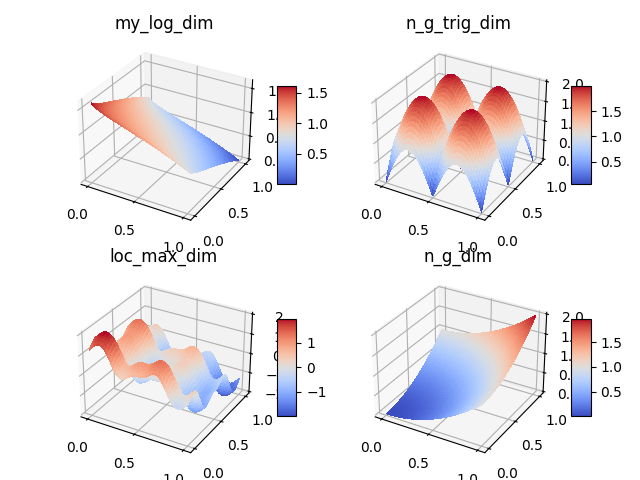

In [25]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

N = 100
all_z = [torch.linspace(-10*torch.pi, 10*torch.pi, N) for _ in range(d)]
x = torch.linspace(0, 1, N)
y = torch.linspace(0, 1, N)
X, Y = torch.meshgrid(x,y)
z = torch.stack((X.flatten(), Y.flatten()), dim=1)
print(z)
func_Fzs = [my_log_dim ,n_g_trig_dim ,loc_max_dim ,n_g_dim ] 
Fz = [f(z, d = 1) for f in func_Fzs]


# z_np = z.squeeze(0).detach().numpy()
# print(z_np)
Fz_np = [fz.detach().numpy().reshape(N, N) for fz in Fz]

# Z = Fz_np[0]


# fig, ax = plt.subplots( subplot_kw={"projection": "3d"})

# # Make data.
# X, Y = X.detach().numpy(), Y.detach().numpy()


# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter('{x:.02f}')

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()


# Make figure with one subplot per Fz
fig = plt.figure()#figsize=(5 * len(Fz_np), 5))

for i, Z in enumerate(Fz_np):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')

    surf = ax.plot_surface(
        X, Y, Z,
        cmap=cm.coolwarm,
        linewidth=0,
        antialiased=False
    )

    ax.set_title(f"{func_Fzs[i].__name__}")
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter('{x:.02f}')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.tight_layout()

plt.show()


Epoch [0/50], Loss: 0.4733
Epoch [1/50], Loss: 0.0580
Epoch [2/50], Loss: 0.0577
Epoch [3/50], Loss: 0.0574
Epoch [4/50], Loss: 0.0572
Epoch [5/50], Loss: 0.0569
Epoch [6/50], Loss: 0.0561
Epoch [7/50], Loss: 0.0557
Epoch [8/50], Loss: 0.0558
Epoch [9/50], Loss: 0.0558
Epoch [10/50], Loss: 0.0557
Epoch [11/50], Loss: 0.0557
Epoch [12/50], Loss: 0.0556
Epoch [13/50], Loss: 0.0555
Epoch [14/50], Loss: 0.0555
Epoch [15/50], Loss: 0.0555
Epoch [16/50], Loss: 0.0554
Epoch [17/50], Loss: 0.0554
Epoch [18/50], Loss: 0.0552
Epoch [19/50], Loss: 0.0549
Epoch [20/50], Loss: 0.0529
Epoch [21/50], Loss: 0.0520
Epoch [22/50], Loss: 0.0522
Epoch [23/50], Loss: 0.0518
Epoch [24/50], Loss: 0.0518
Epoch [25/50], Loss: 0.0516
Epoch [26/50], Loss: 0.0521
Epoch [27/50], Loss: 0.0492
Epoch [28/50], Loss: 0.0451
Epoch [29/50], Loss: 0.0441
Epoch [30/50], Loss: 0.0438
Epoch [31/50], Loss: 0.0435
Epoch [32/50], Loss: 0.0433
Epoch [33/50], Loss: 0.0433
Epoch [34/50], Loss: 0.0430
Epoch [35/50], Loss: 0.0429
Ep

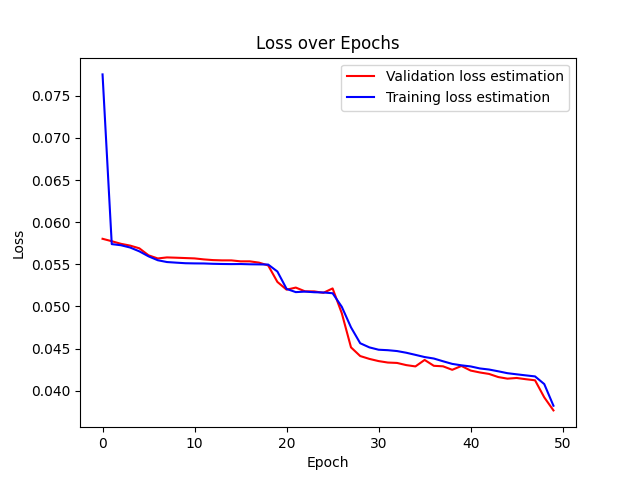

dimension = 2
layers.0.weight:
tensor([[ 1.2556,  0.9847],
        [ 1.0539, -0.4883],
        [ 1.0098, -1.2814],
        [ 0.3801,  0.9580]], device='cuda:0')

layers.0.bias:
tensor([-1.2136,  0.4659,  0.6224, -0.0219], device='cuda:0')

layers.1.weight:
tensor([[-0.2934,  0.3439, -0.5043, -0.8421],
        [ 0.9738, -0.3232,  1.4789, -0.4664],
        [ 3.8320,  0.1860,  0.6183, -2.5103],
        [-1.3672,  0.8860,  0.9999, -0.3380]], device='cuda:0')

layers.1.bias:
tensor([-0.2196,  0.0676,  0.1311,  0.2504], device='cuda:0')

layers.2.weight:
tensor([[ 0.3110,  0.7618, -1.2067, -0.2647],
        [-0.4188, -0.8080,  0.2793, -1.8423],
        [-0.8321,  0.7691, -0.8797, -0.5719],
        [ 0.1726,  0.2874, -0.0929, -0.0979]], device='cuda:0')

layers.2.bias:
tensor([ 0.3171,  0.3426,  0.7598, -0.4505], device='cuda:0')

layers.3.weight:
tensor([[ 0.3688, -1.2739,  0.6385,  0.0371]], device='cuda:0')

layers.3.bias:
tensor([0.2502], device='cuda:0')

WB[0] = 1.2556f;
WB[1] = 0.9847f

In [19]:
#----------------------------------------------------------
# Train, save, reload, and extract weights from a neural network
# ----------------------------------------------------------
# save_NN_path(my_log_dim, dim = d)
save_NN_path(n_g_trig_dim, dim = d)
# save_NN_path(loc_max_dim, dim = d)
# save_NN_path(n_g_dim, dim = d)

# load the model to compute cdf

#model_nn = LeakyNN_weight(d, hn, hn, 1).cuda(device)
model_nn = LeakyNN(L).cuda(device)
model_load = load_checkpoint(model_nn)

print("dimension = " + str(d))
weights = conversion_weights(model_load)

Max scalar outputs for each size (10^i): [0.7409241795539856, 0.9523876905441284, 0.9933702945709229, 1.0296554565429688, 1.032226800918579, 1.0345577001571655, 1.0348320007324219]


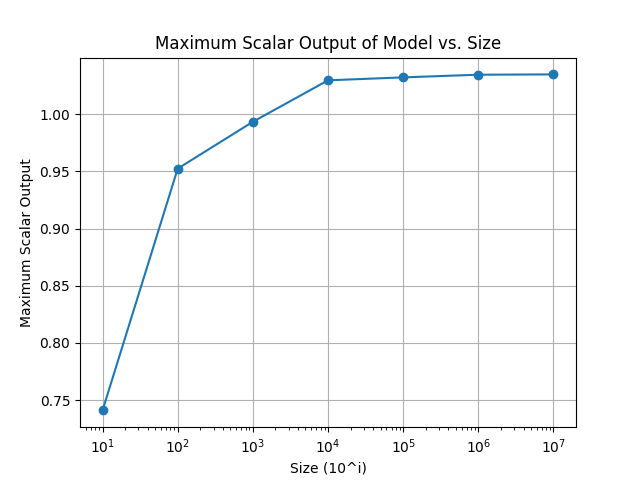

In [20]:
evaluate_model(model_nn, 7, d, device)

In [21]:
np.savetxt("weights.txt", weights)

In [3]:
if "d" not in vars():
    d = 2
if d == 2:
    print(d)
    !nvcc --compiler-bindir=/usr/bin/g++-13 -arch=compute_86 -code=sm_86 -lm MC2V.cu -o MC
elif d == 3:
    print(d)
    !nvcc --compiler-bindir=/usr/bin/g++-13 -arch=compute_86 -code=sm_86 -lm MC3V.cu -o MC
else:
    print("Invalid dimension. Please set dimension to 2 or 3.")

2


In [4]:
!./MC

read done of weights: 57 floats.
Current CUDA stack size: 1024 bytes
Current CUDA stack size: 65536 bytes
The computed Minimum level 0.187724
The computed Maximum level 1.035003
Number of levels 10
With notation (index of pol, number of vertices, number of levels), the non-empty polytopes are:
(239, 6, 6), (494, 6, 5), (495, 9, 9), (1254, 5, 4), (1262, 8, 5), (1263, 8, 8), (1418, 8, 6), (1419, 6, 6), (1422, 8, 7), (1423, 8, 7), (1454, 8, 7), (1455, 8, 8), (1518, 12, 9), (1519, 10, 10), (1647, 7, 5), (1775, 8, 7), (1800, 5, 4), (1802, 8, 5), (1803, 6, 5), (1807, 8, 5), (1839, 8, 8), (1903, 8, 8), (1930, 10, 9), (1931, 10, 9), (1935, 8, 5), (1967, 8, 5), (2031, 8, 8), 
The number of non-empty polytopes: 27
Execution time 67.777084 ms


In [5]:
# TO profile 
# nsys profile -t nvtx,cuda --stats=true --force-overwrite true --wait=all -o my_report ./MC